In [2]:
import torch
from transformers import AutoModel,AutoConfig,AutoTokenizer,ElectraForSequenceClassification,Trainer,TrainingArguments,DataCollatorWithPadding
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict
import evaluate
import re

In [2]:
%%time
# 加载数据
excel_file = '../SRP/10w.xlsx'
data_frame = pd.read_excel(excel_file)

CPU times: user 22.7 s, sys: 113 ms, total: 22.8 s
Wall time: 22.8 s


In [3]:
# # 随机抽样（预实验使用）
# data_frame = data_frame.sample(n=10000)
# data_frame

In [4]:
# 停用词预处理
stop_words = ['您好','你好',':很高兴为您服务','请问有什么可以帮您','client','user',' ']
def ProcessStopWords(text):
    for word in stop_words:
        text = text.replace(word,'')
    text = text.replace(':','。').replace('。','',1)
    return text

data_frame['转写文本'] = data_frame['转写文本'].map(ProcessStopWords)

In [5]:
data_frame['转写文本'].iloc[0]

'哎我想问一下,我这个一三九的号码那个扣费方式是怎么样的。扣费方式的话它是每个月呢就是每个月的一个基本月租,49.7元,然后的话加上您的副卡十块钱,然后的话每个月就是五十九块七毛钱这样子的一个月,月租每个月1,一号再这样子扣月。不是我是问是从那个,银行里面因为是这样子我是从联,呃移动刚刚转过来的我以前绑定的是,建行的那个什么银行卡,是先付费后扣,给我扣款,我想问一下就是这么转过来了你那里有,我的那个什么,银行扣款方式吗还是。没有的。那我这个话费怎么交呢。话费的话您直接在app上面进行一个充值就可以了。是先付费还是后付费的。先付费的,哦。我这个,呃号码现在有充钱吗。这边的话查询到除了,这个月没有的然后的话看到您,最近1期充值就是在11月,月份的1号充的。充了多少钱呢。两百块钱。哦现在还有余额多少呢。二十块七毛五。哦就是每个月我自己就是在,App上查然后不够了我就充钱是吗。嗯是的。那你们有那个什么欠费提醒吗。哦这边都是会有短信这边提醒的。这边还有什么可以帮您呢。没有了好谢谢那您稍后收到短信回复一下数字1,谢谢您再见'

In [6]:
# 标签预处理
regex = re.compile(r'^.*?>(.*?)>.*?$')
def ProcessLabels(text):
    text = text.replace('>>','>').replace('10019','')
    text = re.match(regex, text).groups()[0]
    return text

data_frame['服务请求'] = data_frame['服务请求'].map(ProcessLabels)

In [7]:
# 预览预处理结果
data_frame['转写文本'].iloc[:10]

0    哎我想问一下,我这个一三九的号码那个扣费方式是怎么样的。扣费方式的话它是每个月呢就是每个月的...
1    喂我那个宽带不能用。宽带故障了是吗。哦现在不能用前前几天就不能用了。稍等我帮您看一下。嗯稍等...
2    哎我我办理这个那个我想问一下我这个号码有没有开通5g套餐呀。我看一下您这里有开通5g业务可以...
3    请不要挂机您拨叫的用户正在通话中请唔好挂机您拨叫凯用户正在通话中。。嗯由于您多次没有声音我将...
4    喂我想咨询一下我的那个联通卡怎么回事啊,我都没用过。嗯您可以提供一下吗。这个号码就是我我号码...
5    嗯我想问一下我这个卡是啊升了5g上次是帮我升了5g然后现在是月租是54.5元上网费又是30一...
6                                               不要我有卡。
7    我的号码为啥暂暂停服务了。稍等一下。我帮您看了一下的话您之前的话有反映过这个问题的是吧。然后...
8    哎你查一下我这个话费还有余额吗。您这边还有8.95元。怎么打不了怎么没有信号呢网络没有了呢。...
9    哎先生。哦。嗯我想问一下现在如果这个号码要补号码的话那个身份证复印件有没有有效的。补卡补卡要...
Name: 转写文本, dtype: object

In [8]:
# 训练复盘并分析数据集后，考虑在前面的处理把 样本数<1000 的剔除，即剔除下列：
rm_labels = ['临时','其他','商机','资料信息','业务变更问题','投诉','故障']
for rm_label in rm_labels:
    data_frame.drop(data_frame[data_frame.服务请求 == rm_label].index, inplace=True)
data_frame

,接触ID,用户号码,来电时间,服务请求,转写文本
0,202301111449223447862S1,13924661819,2023-01-11 14:49:25,查询,"哎我想问一下,我这个一三九的号码那个扣费方式是怎么样的。扣费方式的话它是每个月呢就是每个月的..."
1,2023011214193335844424S1,15817930939,2023-01-12 14:19:37,不满,喂我那个宽带不能用。宽带故障了是吗。哦现在不能用前前几天就不能用了。稍等我帮您看一下。嗯稍等...
2,2023011117584374443240S1,18682452380,2023-01-11 17:58:48,咨询,哎我我办理这个那个我想问一下我这个号码有没有开通5g套餐呀。我看一下您这里有开通5g业务可以...
3,2023011111224925142885S1,17520581290,2023-01-11 11:22:53,无效来话,请不要挂机您拨叫的用户正在通话中请唔好挂机您拨叫凯用户正在通话中。。嗯由于您多次没有声音我将...
4,2023011116155634245935S1,18929735508,2023-01-11 16:16:00,无效来话,"喂我想咨询一下我的那个联通卡怎么回事啊,我都没用过。嗯您可以提供一下吗。这个号码就是我我号码..."
...,...,...,...,...,...
99995,2023011518563077444424S1,13192805729,2023-01-15 18:56:34,咨询,呃你你帮我查一下我这个卡是是办了个流流量王卡吗怎么会饿这这1天不到就扣了23块多是怎么扣的了...
99996,2023011312500975848096S1,17666518437,2023-01-13 12:50:14,不满,喂。我那个啥我那个有个流量扣我30块钱咋扣的。流量扣费嘛那是十二月份的。啊应该是吧十二月份还...
99997,2023011214322475442931S1,18588258108,2023-01-12 14:32:28,办理,哎我问一下就是我之前好像你们有跟我说我有一个什么宽带可以。把。什么优惠还是怎么考虑。安装。对...
99998,2023011212102419845872S1,18582242369,2023-01-12 12:10:28,查询,"哎,我想问一下,我那个我那个,怎么有个20多块钱的那个增值业务是什么。是您来电这一个号码吗。..."


In [9]:
prompts = np.array(data_frame['转写文本'])
choices = np.array(data_frame['服务请求'])

In [10]:
data_frame['服务请求']

0          查询
1          不满
2          咨询
3        无效来话
4        无效来话
         ... 
99995      咨询
99996      不满
99997      办理
99998      查询
99999      办理
Name: 服务请求, Length: 99939, dtype: object

In [11]:
# 取最大长度
data_frame.insert(data_frame.shape[1], 'text_len',None)
data_frame['text_len'] = data_frame['转写文本'].map(len)
max_length_index = data_frame['text_len'].argmax()
max_length = data_frame['text_len'].iloc[max_length_index]
max_length_index, max_length

(72847, 4443)

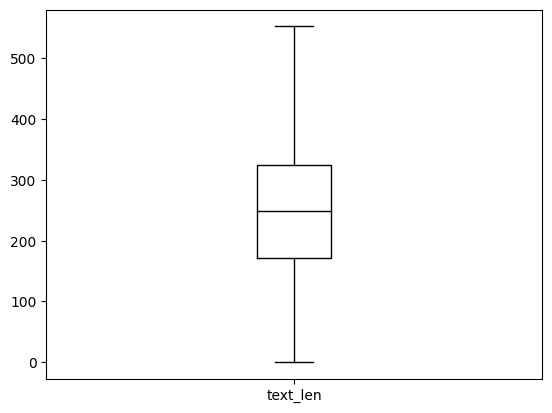

In [12]:
# 观察文本长度分布（排除异常值）
data_frame.boxplot('text_len', grid=False, showfliers=False, color='Black')
plt.suptitle("")
plt.xlabel("")
plt.show()
# 由图可知，取512足够覆盖正常样本
max_length = 512

In [13]:
# 去重choices，并保存原choices对应去重后的位置
unique_choices = np.unique(choices)
labels = np.array([np.argwhere(unique_choices==v)[0]  for v in choices])
unique_choices.shape, labels.shape

((5,), (99939, 1))

In [14]:
# 加入标签
data_frame.insert(0, 'label', value=labels)
data_frame[:10]

,label,接触ID,用户号码,来电时间,服务请求,转写文本,text_len
0,4,202301111449223447862S1,13924661819,2023-01-11 14:49:25,查询,"哎我想问一下,我这个一三九的号码那个扣费方式是怎么样的。扣费方式的话它是每个月呢就是每个月的...",461
1,0,2023011214193335844424S1,15817930939,2023-01-12 14:19:37,不满,喂我那个宽带不能用。宽带故障了是吗。哦现在不能用前前几天就不能用了。稍等我帮您看一下。嗯稍等...,450
2,2,2023011117584374443240S1,18682452380,2023-01-11 17:58:48,咨询,哎我我办理这个那个我想问一下我这个号码有没有开通5g套餐呀。我看一下您这里有开通5g业务可以...,212
3,3,2023011111224925142885S1,17520581290,2023-01-11 11:22:53,无效来话,请不要挂机您拨叫的用户正在通话中请唔好挂机您拨叫凯用户正在通话中。。嗯由于您多次没有声音我将...,68
4,3,2023011116155634245935S1,18929735508,2023-01-11 16:16:00,无效来话,"喂我想咨询一下我的那个联通卡怎么回事啊,我都没用过。嗯您可以提供一下吗。这个号码就是我我号码...",375
5,4,2023011211202452445985S1,13268380631,2023-01-12 11:20:29,查询,嗯我想问一下我这个卡是啊升了5g上次是帮我升了5g然后现在是月租是54.5元上网费又是30一...,186
6,0,2023011221392818042574S1,18507625784,2023-01-12 21:41:50,不满,不要我有卡。,6
7,0,2023011119235563644186S1,18575338828,2023-01-11 19:23:59,不满,我的号码为啥暂暂停服务了。稍等一下。我帮您看了一下的话您之前的话有反映过这个问题的是吧。然后...,212
8,0,2023011214073176245834S1,13106672198,2023-01-12 14:07:36,不满,哎你查一下我这个话费还有余额吗。您这边还有8.95元。怎么打不了怎么没有信号呢网络没有了呢。...,209
9,4,2023011106133663642968S1,13215222179,2023-01-11 14:13:39,查询,哎先生。哦。嗯我想问一下现在如果这个号码要补号码的话那个身份证复印件有没有有效的。补卡补卡要...,79


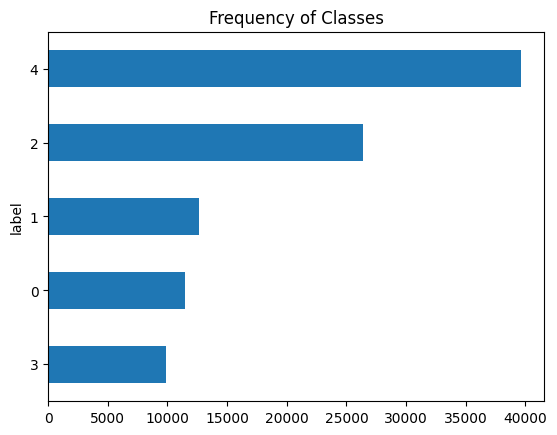

In [15]:
# 取出特征与labels
df = data_frame[['label', '转写文本', '服务请求']]
df[:10]
# 统计
df['label'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [16]:
# 创建数据集
ds = DatasetDict({'train': Dataset.from_pandas(df)})
# ds['train'] = ds['train'].rename_column('转写文本','text')
ds = ds.remove_columns(['服务请求'])
ds['train'] = ds['train'].rename_columns({'转写文本':'text'})
ds = ds['train'].train_test_split(0.2, shuffle=True) # 按 8:2 分割数据集
ds, ds['train'][0], ds['test'][0]

(DatasetDict({
     train: Dataset({
         features: ['label', 'text', '__index_level_0__'],
         num_rows: 79951
     })
     test: Dataset({
         features: ['label', 'text', '__index_level_0__'],
         num_rows: 19988
     })
 }),
 {'label': 0,
  'text': '你帮我查一下充完话费了为什么还是用不了流量。嗯这边帮您看到的话已经是恢复正常可以使用哦您那边有没有关机重启过。没有关机重启过。嗯您那边。嗯。您那边要关机呀。要关机吗。嗯对关机3到5分钟之后重启一下帮您看到已经是恢复正常可以使用的哈。哦那好的谢谢。嗯好不用客气那这边还有其他业务需要咨询。没有了。好那不打扰您祝您生活愉快再见',
  '__index_level_0__': 84727},
 {'label': 3,
  'text': '就是我这个话我这个手机号才50多g的那个流量但是为什么它用起来会非常的卡呢。是到任何位置还是在一个位置啊。就是就是它用起来非常的卡这个流量我不知道是什么原因。目前看到后台都正常的那您稍后按照我这个短信操作反映一下网络设置以后再试一下可以吗。哦好怎么操作。已经下发短信给您了您按照短信操作就可以了。好的好的谢谢谢谢。好的没事那感谢来电祝您生活愉快再见',
  '__index_level_0__': 38886})

In [17]:
%%time
model_path = './chinese-electra-base-discriminator/'
tokenizer = AutoTokenizer.from_pretrained(model_path)
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=max_length)

tokenized_ds = ds.map(preprocess_function, batched=True)

Map: 100%|██████████| 19988/19988 [00:05<00:00, 3751.06 examples/s]

CPU times: user 2min 59s, sys: 908 ms, total: 3min
Wall time: 26.9 s


In [18]:
# 模型
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # 允许不同长度tensor的存在
model_config = AutoConfig.from_pretrained(model_path)
model_config.num_labels = unique_choices.shape[0]
model = ElectraForSequenceClassification(model_config)

In [19]:
tokenized_ds['train'][0]

{'label': 0,
 'text': '你帮我查一下充完话费了为什么还是用不了流量。嗯这边帮您看到的话已经是恢复正常可以使用哦您那边有没有关机重启过。没有关机重启过。嗯您那边。嗯。您那边要关机呀。要关机吗。嗯对关机3到5分钟之后重启一下帮您看到已经是恢复正常可以使用的哈。哦那好的谢谢。嗯好不用客气那这边还有其他业务需要咨询。没有了。好那不打扰您祝您生活愉快再见',
 '__index_level_0__': 84727,
 'input_ids': [101,
  872,
  2376,
  2769,
  3389,
  671,
  678,
  1041,
  2130,
  6413,
  6589,
  749,
  711,
  784,
  720,
  6820,
  3221,
  4500,
  679,
  749,
  3837,
  7030,
  511,
  1638,
  6821,
  6804,
  2376,
  2644,
  4692,
  1168,
  4638,
  6413,
  2347,
  5307,
  3221,
  2612,
  1908,
  3633,
  2382,
  1377,
  809,
  886,
  4500,
  1521,
  2644,
  6929,
  6804,
  3300,
  3766,
  3300,
  1068,
  3322,
  7028,
  1423,
  6814,
  511,
  3766,
  3300,
  1068,
  3322,
  7028,
  1423,
  6814,
  511,
  1638,
  2644,
  6929,
  6804,
  511,
  1638,
  511,
  2644,
  6929,
  6804,
  6206,
  1068,
  3322,
  1435,
  511,
  6206,
  1068,
  3322,
  1408,
  511,
  1638,
  2190,
  1068,
  3322,
  124,
  1168,
  126,
  1146,
  7164,
  722,
  1400,
  7028,
  1423,
  671,
  678,
  2

In [20]:
# 评估
accuracy = evaluate.load('./evaluate/metrics/accuracy/accuracy.py')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [25]:
# 训练参数
training_args = TrainingArguments('./output',evaluation_strategy='epoch',save_strategy='epoch', learning_rate=5e-7, 
                                  load_best_model_at_end=True, num_train_epochs=3)
trainer = Trainer(model, args=training_args, train_dataset=tokenized_ds['train'], eval_dataset=tokenized_ds['test'], 
                  tokenizer=tokenizer, data_collator=data_collator, compute_metrics=compute_metrics)

In [26]:
%%time
# 训练
trainer.train(resume_from_checkpoint=False)

Epoch,Training Loss,Validation Loss,Accuracy
6,1.454600,1.454980,0.397639


CPU times: user 49min 51s, sys: 1min 20s, total: 51min 12s
Wall time: 51min 3s


TrainOutput(global_step=59964, training_loss=0.24305251854827903, metrics={'train_runtime': 3062.1515, 'train_samples_per_second': 156.657, 'train_steps_per_second': 19.582, 'total_flos': 9.609648335062744e+16, 'train_loss': 0.24305251854827903, 'epoch': 6.0})